<a href="https://colab.research.google.com/github/RDW287/CM3710-Coding-Assessment/blob/main/AI_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/RDW287/CM3710-Coding-Assessment
%cd CM3710-Coding-Assessment/
!git pull

fatal: destination path 'CM3710-Coding-Assessment' already exists and is not an empty directory.
/content/CM3710-Coding-Assessment
Already up to date.


In [3]:
# Required imports for code
import os
import re
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from PIL import Image
from tensorflow import keras
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

#**Introduction**

The aim of this notebook is to create and compare to two AI algorithms to classify images from the selected dataset. The dataset is images captured using Meta glass, these include rooms and objects within RGU that are categorized/labelled by name. We will be using solely the objects to reduce runtime.

The models will be trained, tested and compared to find the most suitable algorithm for the task of image classification.

No. Images:  40
Image Size: (360, 360)


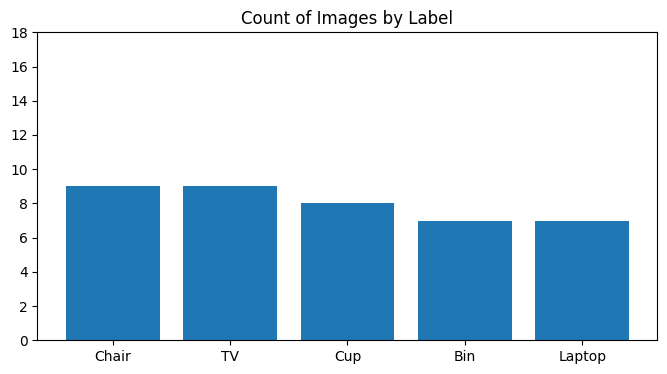

In [4]:
# Data Exploration

directory = "RGU_Images" #The name of the folder containing the images

# Stores the names of the files, this will be used as the labels later
image_filenames = []
files = []
for file in os.listdir(directory):
  name = re.split('_|-', file) #Splits file names by _ and - to get the label as the names are like 1-Bin_1.jpeg
  if name[1] in ("Cup", "TV", "Bin", "Chair", "Laptop"): #We are only looking at the objects rather than the rooms
    image_filenames.append(name[1])
    files.append(file)

# We can see that we have 40 images that are 360x360 pixels in size
print("No. Images: ", len(files))
print("Image Size:", Image.open(f'{directory}/{files[0]}').size)

# Gets the count of each label in the dataset
filename_count = Counter(image_filenames)

# The bar graph below shows that each category has between 7 and 9 images for each, this isnt a large dataset so image augmentation will be required to increase it.
plt.figure(figsize=(8,4))
plt.bar(filename_count.keys(), filename_count.values())
plt.yticks(range(0,20,2))
plt.title("Count of Images by Label")
plt.show()

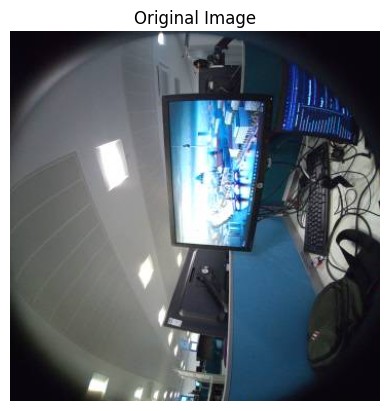

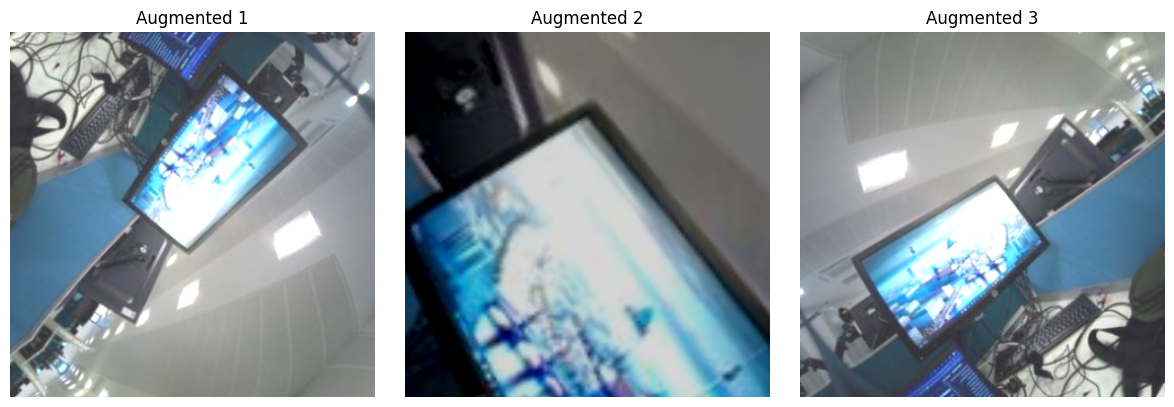

In [5]:
# Data Preprocessing

# We will create a keras layer to apply augmentation techniques to expand our training set, this allows the models to spot trend in images when noise is added
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical", seed=1), #Flips the image horizontally and/or vertically
    keras.layers.RandomRotation(0.5, seed=1), #Adds some rotation to the image
    keras.layers.RandomZoom((-0.75,0), seed=1), #Zooms into a particular point by 0% - 75% allowing it to learn patterns in small areas of the image
    keras.layers.RandomBrightness(factor=0.2, seed=1), #Changes the brightness of the image
    keras.layers.Rescaling(1./255.) #This will scale the image contents to between 0-1, this is min-max normalisation
])

# This is what the original image looks like
img = plt.imread(f'{directory}/{files[1]}')
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# These are examples of how the images will look after augmentation
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    augmented = data_augmentation(img)
    axs[i].imshow(augmented)
    axs[i].set_title(f"Augmented {i + 1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Now we need to create our dataset with the augmented images
images = []
for file in files:
  image = Image.open(f'{directory}/{file}')
  images.append(np.array(image))
images = np.array(images) #We will use a numpy array for compatability with future methods

# We need to convert the labels from the file names into one-hot vectors, it will create an n length array with 0 in every column apart from the one where it matches the label
y_categorical = keras.utils.to_categorical(
    np.unique(image_filenames, return_inverse=True)[1]
)
print("Categorical Vector Example:", y_categorical[0])

# A train test split will be used to leave 40% of the training set as unseen data for testing. This prevents overfitting of the model and allows us to test its suitability on unseen images
X_train, X_test, y_train, y_test = train_test_split(
    images,
    y_categorical,
    test_size=0.4, #40% of the entire dataset is set aside, this will not include augmented images as this would cause accuracy overestimation due to small parts of the training data being in the test set
    stratify=y_categorical, #This is a sampling method to help preserve the proportions in our data, it prevents certain low occurring categories not appearing in our test at all
    random_state=1 #Sets a seed so split is the same for everyone who runs this
)

# Now we need to add in our augmented data into our training set, we did this after the split to prevent pieces of training data sneaking into our test set
for x,y in zip(X_train, y_train):
  for j in range(10): #We will create 10 augmented images for each image in our training set, this may take a couple minutes
    augmented = np.array(data_augmentation(x))
    X_train = np.append(X_train, [augmented], axis=0)
    y_train = np.append(y_train, [y], axis=0)

print("New Training Set Size: ", len(X_train))

Categorical Vector Example: [0. 1. 0. 0. 0.]
New Training Set Size:  264


#**Algorithm 1 - Convolutional Neural Network (CNN)**

A CNN is a variation of a neural network, an algorithm based off the human brain, that is often applied to images. It contains Convolution and Max Pooling layers that discover features in the image and summarize, compressing the image while maintaining its features by applying filters across the image.

This is then passed to a dense layer which is a typical neural network containing neurons that take in weights and biases, use an activation function to introduce some non-linearity, and uses backpropogation to train it.

Finally, as it is a classification exercise, it uses softmax to calculate the probability that it falls into each of the classes and picks the one with the biggest chance as the final prediction

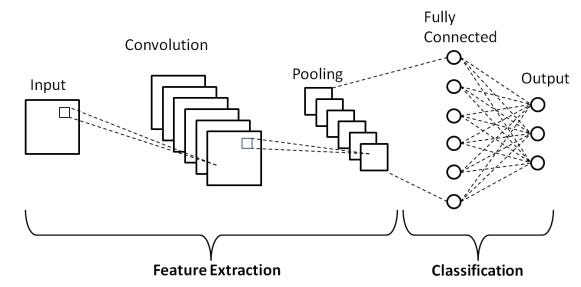

In [8]:
CNN = keras.models.Sequential([
    keras.Input(shape=(360,360,3)), #Specifies that the image is 360x360
    # 1st Convolution block
    keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'), #The convolution layer will have 16 3x3 filters
    keras.layers.MaxPooling2D(pool_size=(2,2)), #The pooling layer will summarise the image in 2x2 sections

    # 2nd Convolution block
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # 3rd Convolution block
    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # 4th Convolution block
    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Flatten(), #Turns the image from a nested array into a vector
    keras.layers.Dense(len(y_categorical[0]), activation="softmax"), #The softmax function in the output layer will weight the probability of the image being one of the classes
])

# We will fit the training data to the model, "adam" uses stochastic gradient descent to optimize the network
CNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "f1_score"])
CNN.fit(X_train, y_train, epochs=10) #10 Epochs means it will run over the full training set 10 times

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.2382 - loss: 8.2428
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.2756 - loss: 2.1292
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.2868 - loss: 1.4214
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.2982 - loss: 1.4136
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.4466 - loss: 1.3321
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5254 - loss: 1.2700
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.5230 - loss: 1.1936
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6296 - loss: 1.0367
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6152 - loss: 1.0155
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.6130 - loss: 0.9735


#**Algorithm 2 - Random Forest**

A Random Forest Algorithm is a method that builds multiple decision trees, it trains each tree on a random set of the data which prevents the overfitting issues in a single tree. Each tree will recieve an image and make a vote for the class it predicts it will be, the majority class is outputted for the final decision. Since each tree is different it allows it to find trends through noise.

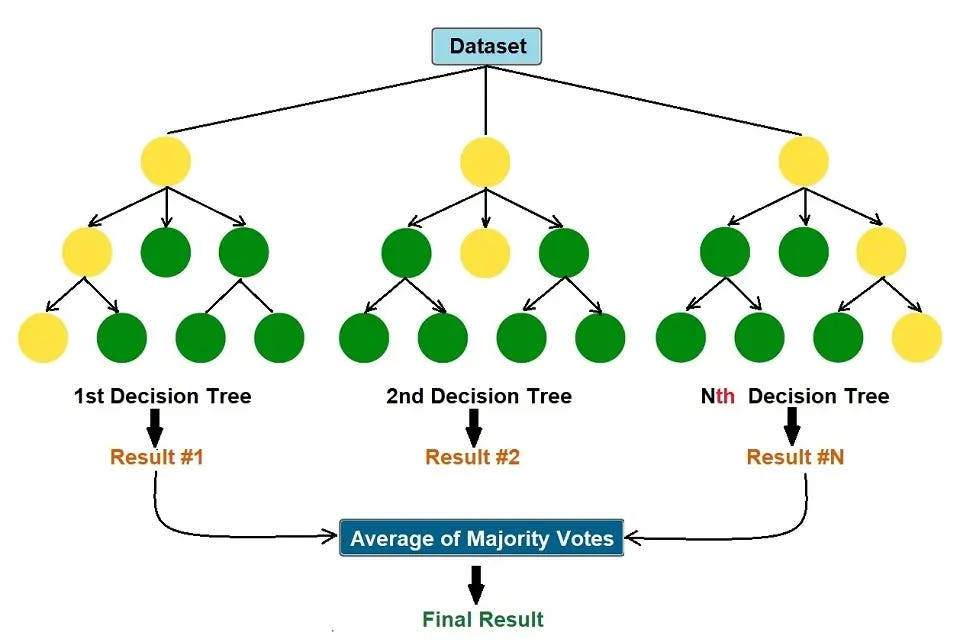


In [14]:
# Algorithm 2 - Random Forest

# As sklearn doesnt accept an array with the same dimensions as tensorflow, we'll neded to flatten them
samples, x, y, rgb = X_train.shape
X_train_reshaped = X_train.reshape((samples,x*y*rgb))

samples, x, y, rgb = X_test.shape
X_test_reshaped = X_test.reshape((samples,x*y*rgb))

# We can tune some hyperparemeters to see which perform best, however we need to make a tradeoff between the number of parameters we try and the time it takes to test
param_grid = {
  'bootstrap': [True, False], #Whether to create multiple random samples (with replacement) for training each tree.
  'max_depth': [10, 20, 30], #Sets how many layers deep the tree can go
  'n_estimators': [50, 100, 150] #The total number of trees in the forest
}

# We can now fit the model based off the best performing parameters, by default a 5 fold cross validation is used and it trys 10 different parameter combinations
classifier = RandomForestClassifier()
RFC = RandomizedSearchCV(
    estimator = classifier,
    param_distributions = param_grid,
    random_state = 1,
    verbose = 3
)

RFC.fit(X_train_reshaped, y_train)
print("Best Parameters: ", RFC.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=True, max_depth=30, n_estimators=50;, score=0.189 total time=   5.3s
[CV 2/5] END bootstrap=True, max_depth=30, n_estimators=50;, score=0.396 total time=   5.1s
[CV 3/5] END bootstrap=True, max_depth=30, n_estimators=50;, score=0.264 total time=   3.9s
[CV 4/5] END bootstrap=True, max_depth=30, n_estimators=50;, score=0.283 total time=   4.0s
[CV 5/5] END bootstrap=True, max_depth=30, n_estimators=50;, score=0.096 total time=   5.1s
[CV 1/5] END bootstrap=True, max_depth=20, n_estimators=50;, score=0.170 total time=   3.9s
[CV 2/5] END bootstrap=True, max_depth=20, n_estimators=50;, score=0.396 total time=   4.0s
[CV 3/5] END bootstrap=True, max_depth=20, n_estimators=50;, score=0.283 total time=   5.2s
[CV 4/5] END bootstrap=True, max_depth=20, n_estimators=50;, score=0.340 total time=   3.9s
[CV 5/5] END bootstrap=True, max_depth=20, n_estimators=50;, score=0.058 total time=   3.9s
[CV 1/5] END bootst

#**Algorithm Results**


In [31]:
# We can now once again test the model on our test data

CNN_pred = CNN.predict(X_test)
CNN_eval = CNN.evaluate(X_test, y_test, verbose=0)
print("CNN Test Accuracy:", CNN_eval[1])
#print("CNN F1 Score:", CNN_eval[2])

RFC_pred = RFC.predict(X_test_reshaped)
print("RFC Test Accuracy: ", accuracy_score(y_test, RFC_pred))
print("RFC F1 Score: ", f1_score(y_test, RFC_pred, average='micro'))

print(confusion_matrix(y_test.argmax(axis=1), CNN_pred.argmax(axis=1)))
print(confusion_matrix(y_test.argmax(axis=1), RFC_pred.argmax(axis=1)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
CNN Test Accuracy: 0.875
RFC Test Accuracy:  0.4375
RFC F1 Score:  0.5833333333333334
[[3 0 0 0 0]
 [1 3 0 0 0]
 [1 0 2 0 0]
 [0 0 0 3 0]
 [0 0 0 0 3]]
[[2 1 0 0 0]
 [2 2 0 0 0]
 [3 0 0 0 0]
 [3 0 0 0 0]
 [0 0 0 0 3]]
